In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import scipy as sp
from scipy.ndimage.filters import gaussian_filter1d
import sqlite3 as sql
import os
import pandas as pd
from datetime import datetime
from glob import glob
os.sys.path.append('../')
from utilities import *
from astropy.convolution import convolve, Gaussian1DKernel

%load_ext autoreload
%autoreload 2

%matplotlib inline

C:\Users\mplitt\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# find sessions from single mouse on TwoTower_noTimeout with datestring earlier than or equal to first timeout day
# num rewards greater than 
df = load_session_db()
ca1mice = ['4139190.1','4139190.3', '4054011.1','4139202.2']
dgmice = ['4054010.4','4054010.5']

df = df[df['RewardCount']>10]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime'])
df

,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,DateTime,data file,scanfile,scanmat
145,4054010.4,15_06_2018,2,TwoTower_noTimeout,42,1,2018-06-15,G:\My Drive\\VR_Data\TwoTower\4054010.4\15_06_...,G:\My Drive\2P_Data\TwoTower\4054010.4\15_06_2...,G:\My Drive\2P_Data\TwoTower\4054010.4\15_06_2...
361,4054010.5,15_06_2018,1,TwoTower_noTimeout,49,1,2018-06-15,G:\My Drive\\VR_Data\TwoTower\4054010.5\15_06_...,G:\My Drive\2P_Data\TwoTower\4054010.5\15_06_2...,G:\My Drive\2P_Data\TwoTower\4054010.5\15_06_2...
363,4054010.5,15_06_2018,2,TwoTower_Timeout,45,1,2018-06-15,G:\My Drive\\VR_Data\TwoTower\4054010.5\15_06_...,G:\My Drive\2P_Data\TwoTower\4054010.5\15_06_2...,G:\My Drive\2P_Data\TwoTower\4054010.5\15_06_2...
347,4054010.5,17_06_2018,2,TwoTower_Timeout,78,1,2018-06-17,G:\My Drive\\VR_Data\TwoTower\4054010.5\17_06_...,G:\My Drive\2P_Data\TwoTower\4054010.5\17_06_2...,G:\My Drive\2P_Data\TwoTower\4054010.5\17_06_2...
365,4054010.5,19_06_2018,2,TwoTower_Timeout,57,1,2018-06-19,G:\My Drive\\VR_Data\TwoTower\4054010.5\19_06_...,G:\My Drive\2P_Data\TwoTower\4054010.5\19_06_2...,G:\My Drive\2P_Data\TwoTower\4054010.5\19_06_2...
304,4054011.1,17_06_2018,2,TwoTower_noTimeout,110,1,2018-06-17,G:\My Drive\\VR_Data\TwoTower\4054011.1\17_06_...,G:\My Drive\2P_Data\TwoTower\4054011.1\17_06_2...,G:\My Drive\2P_Data\TwoTower\4054011.1\17_06_2...
311,4054011.1,19_06_2018,2,TwoTower_Timeout,74,1,2018-06-19,G:\My Drive\\VR_Data\TwoTower\4054011.1\19_06_...,G:\My Drive\2P_Data\TwoTower\4054011.1\19_06_2...,G:\My Drive\2P_Data\TwoTower\4054011.1\19_06_2...
306,4054011.1,21_06_2018,2,TwoTower_Timeout,95,1,2018-06-21,G:\My Drive\\VR_Data\TwoTower\4054011.1\21_06_...,G:\My Drive\2P_Data\TwoTower\4054011.1\21_06_2...,G:\My Drive\2P_Data\TwoTower\4054011.1\21_06_2...
212,4139190.1,15_06_2018,3,TwoTower_noTimeout,48,1,2018-06-15,G:\My Drive\\VR_Data\TwoTower\4139190.1\15_06_...,G:\My Drive\2P_Data\TwoTower\4139190.1\15_06_2...,G:\My Drive\2P_Data\TwoTower\4139190.1\15_06_2...
213,4139190.1,15_06_2018,1,TwoTower_noTimeout,56,1,2018-06-15,G:\My Drive\\VR_Data\TwoTower\4139190.1\15_06_...,G:\My Drive\2P_Data\TwoTower\4139190.1\15_06_2...,G:\My Drive\2P_Data\TwoTower\4139190.1\15_06_2...


In [3]:
for mouse in ca1mice+dgmice:
    print(mouse)
    # no timeeout 
    df_noTO = df[df['Track']=='TwoTower_noTimeout']
    df_noTO = df_noTO[df_noTO['MouseName'].str.match(mouse)]
    df_noTO
    # concatenate all files
    data_noTOs = behavior_dataframe([df_noTO['data file'].iloc[i] for i in range(df_noTO.shape[0])],scanmats=[df_noTO['scanmat'].iloc[i] for i in range(df_noTO.shape[0])],concat=False)

    
    # correct for frame times
    for data_noTO in data_noTOs:
        trial_mat, bin_edges, bin_centers = make_pos_bin_trial_matrices(data_noTO[['speed','morph','lick rate','reward','lick']]._values,
                                                          data_noTO['pos']._values,
                                                          data_noTO['tstart']._values,
                                                          data_noTO['teleport']._values,bin_size=5)

        #trial_mat[np.isnan(trial_mat)]=0
        morph_vec,count = sp.stats.mode(trial_mat[:,:,1],axis=1,nan_policy='omit')
        morph_vec = np.squeeze(morph_vec)

         # speed vs position
        speed_dict = trial_type_dict(trial_mat[:,:,0],morph_vec)

        f,ax = plot_speed(bin_centers,speed_dict,morph_vec)
        f.suptitle(mouse)

        # plot licking behavior 
        lick_dict = trial_type_dict(trial_mat[:,:,4],morph_vec)
        lick_mat = np.squeeze(trial_mat[:,:,2])
        lick_mat_norm = lick_dict['all']/np.amax(lick_dict['all'])
        lick_norm_dict = trial_type_dict(lick_mat_norm,morph_vec)
        fig,axes = lick_plot(lick_dict,bin_edges,smooth=False,ratio=True)

    # timeout
    
    # speed vs position
    
    # plot licking behavior 

4139190.1
G:\My Drive\2P_Data\TwoTower\4139190.1\15_06_2018\TwoTower_noTimeout\TwoTower_noTimeout_3_000.mat


C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:276: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  frame['ca inds'] = caInds
C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


G:\My Drive\2P_Data\TwoTower\4139190.1\15_06_2018\TwoTower_noTimeout\TwoTower_noTimeout_1_000.mat
G:\My Drive\2P_Data\TwoTower\4139190.1\16_06_2018\TwoTower_noTimeout\TwoTower_noTimeout_2_000.mat


TypeError: string indices must be integers

4139190.3
G:\My Drive\2P_Data\TwoTower\4139190.3\19_06_2018\TwoTower_Timeout\TwoTower_Timeout_2_000.mat


..\utilities.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  frame['ca inds'] = caInds
C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


G:\My Drive\2P_Data\TwoTower\4139190.3\21_06_2018\TwoTower_Timeout\TwoTower_Timeout_2_000.mat
G:\My Drive\2P_Data\TwoTower\4139190.3\25_06_2018\TwoTower_Timeout\TwoTower_Timeout_2_000.mat
G:\My Drive\2P_Data\TwoTower\4139190.3\28_06_2018\TwoTower_Timeout\TwoTower_Timeout_2_000.mat
G:\My Drive\2P_Data\TwoTower\4139190.3\12_07_2018\TwoTower_Timeout\TwoTower_Timeout_001_004.mat
G:\My Drive\2P_Data\TwoTower\4139190.3\12_07_2018\TwoTower_Timeout\TwoTower_Timeout_002_009.mat
G:\My Drive\2P_Data\TwoTower\4139190.3\12_07_2018\TwoTower_Timeout\TwoTower_Timeout_001_004.mat
G:\My Drive\2P_Data\TwoTower\4139190.3\12_07_2018\TwoTower_Timeout\TwoTower_Timeout_002_009.mat
G:\My Drive\2P_Data\TwoTower\4139190.3\14_07_2018\TwoTower_Timeout\TwoTower_Timeout_016_014.mat
G:\My Drive\2P_Data\TwoTower\4139190.3\14_07_2018\TwoTower_Timeout\TwoTower_Timeout_017_016.mat
G:\My Drive\2P_Data\TwoTower\4139190.3\14_07_2018\TwoTower_Timeout\TwoTower_Timeout_017_016.mat
G:\My Drive\2P_Data\TwoTower\4139190.3\14_07_2

C:\Users\mplitt\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
..\utilities.py:461: RuntimeWarning: Mean of empty slice
  zone1_speed[i] = np.nanmean(sub_frame.loc[zone1_mask,'speed'])
C:\Users\mplitt\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
..\utilities.py:460: RuntimeWarning: Mean of empty slice
  zone0_speed[i]=np.nanmean(sub_frame.loc[zone0_mask,'speed'])


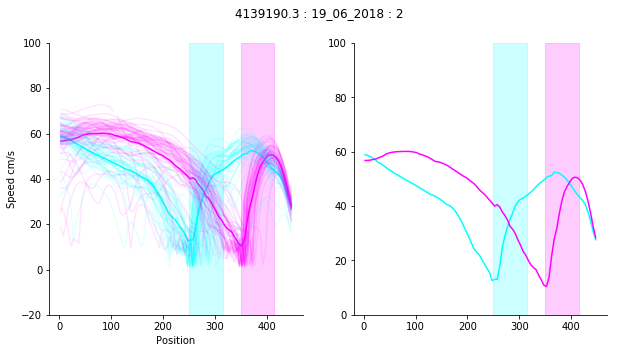

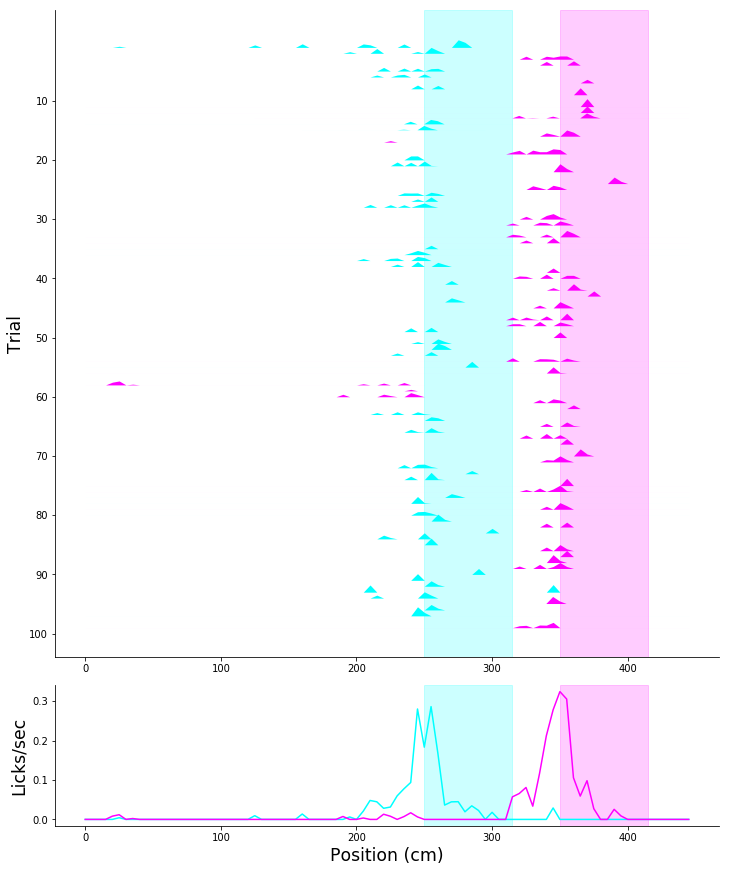

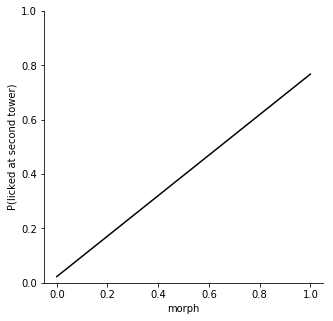

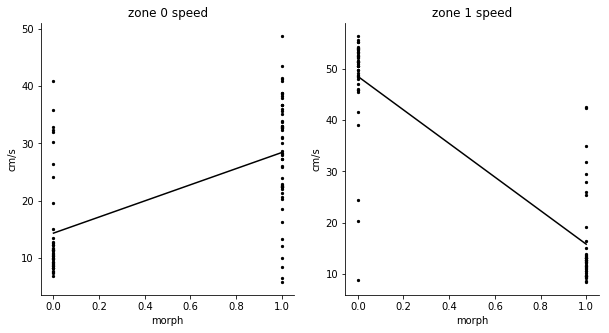

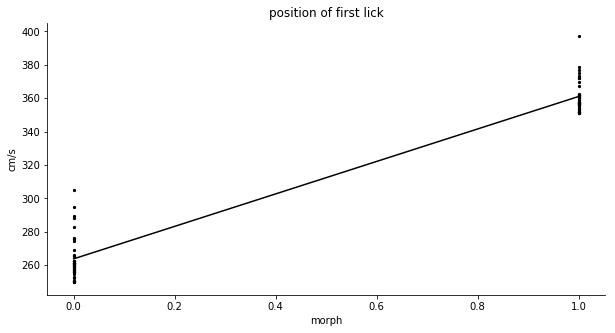

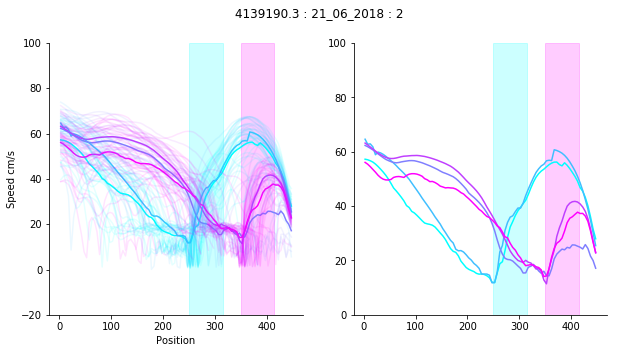

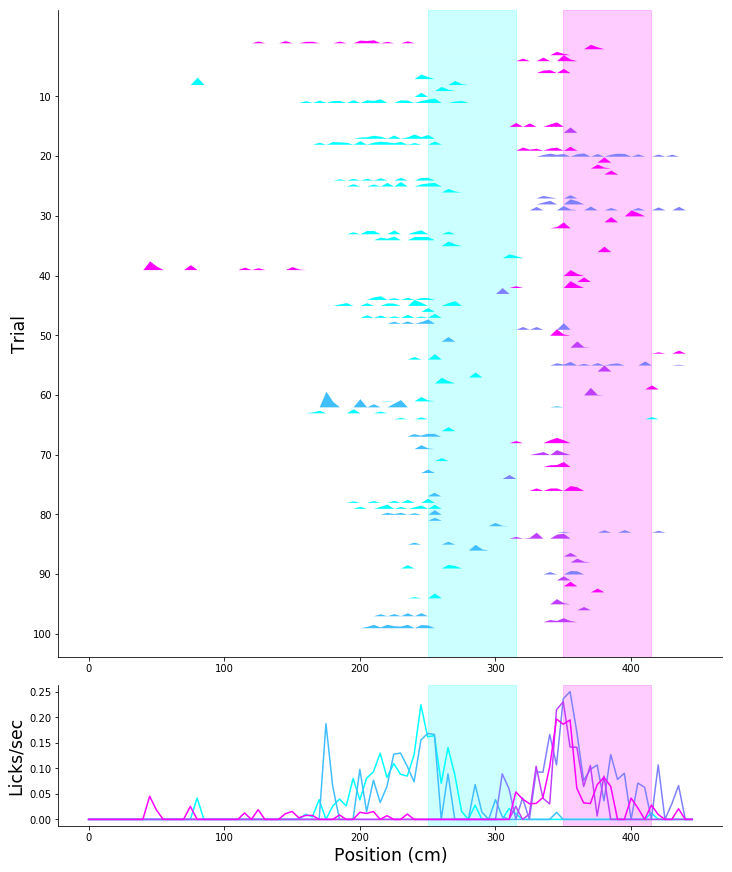

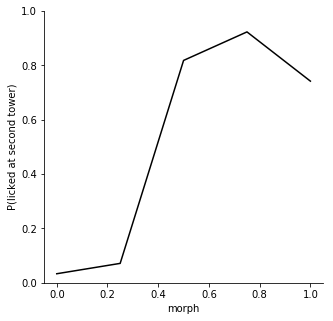

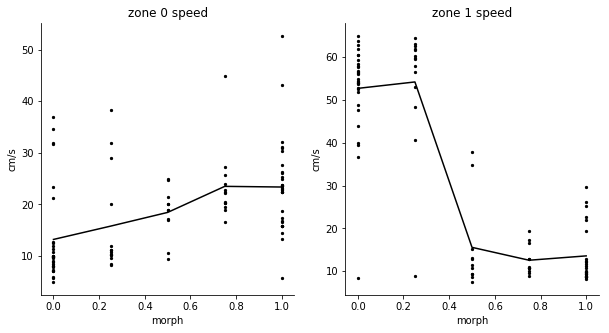

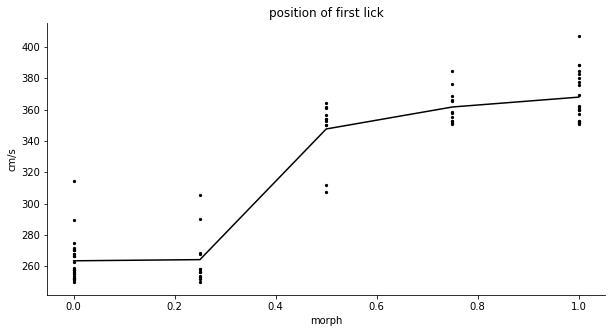

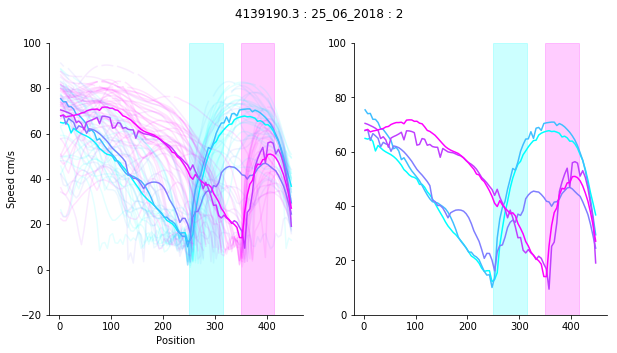

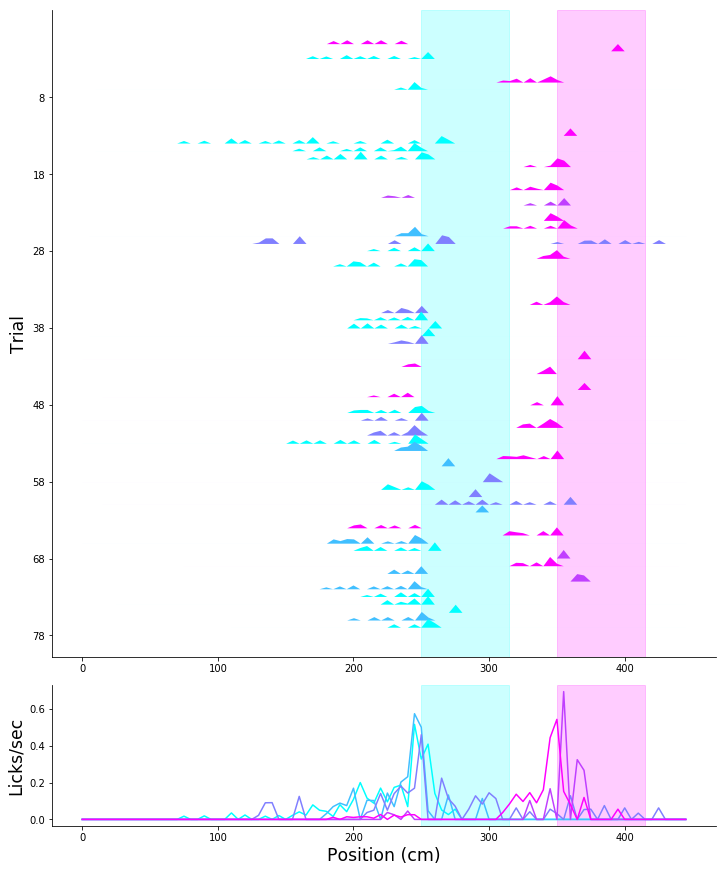

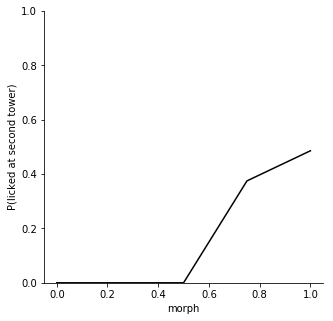

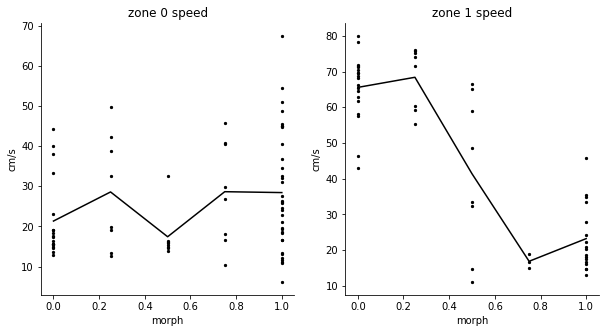

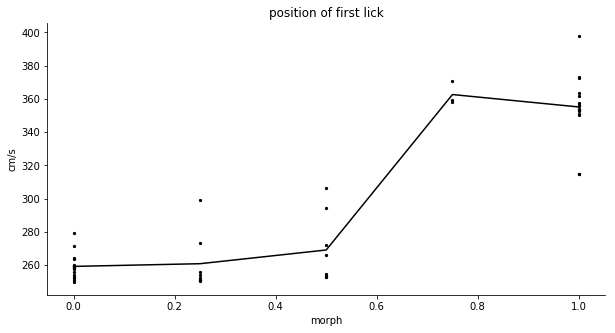

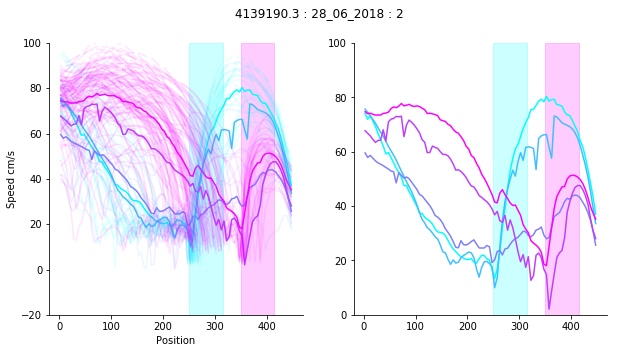

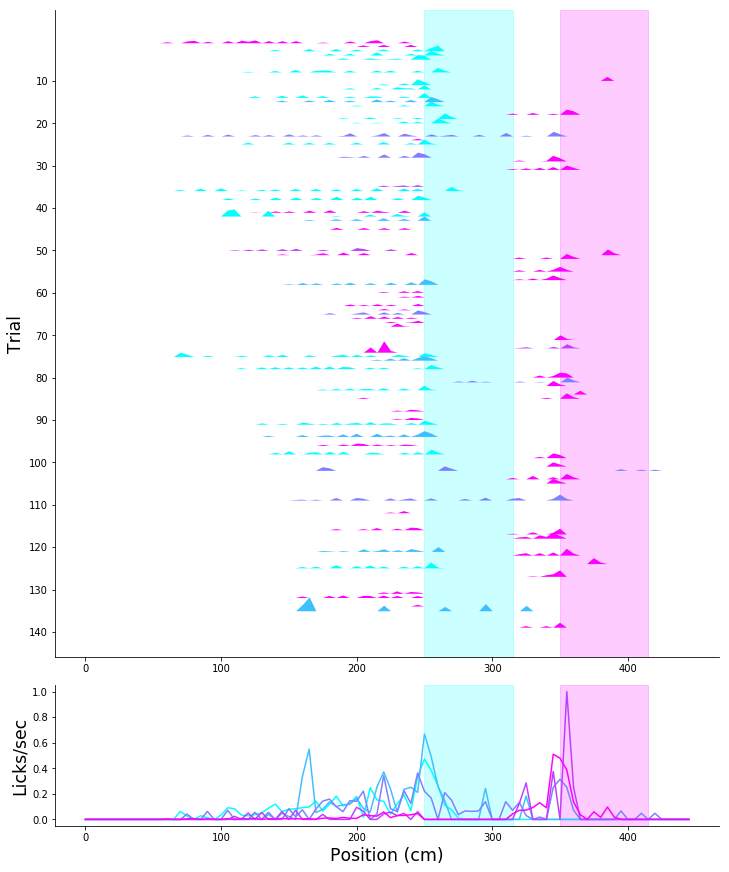

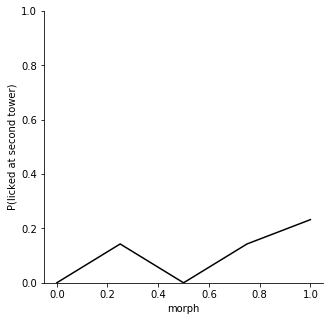

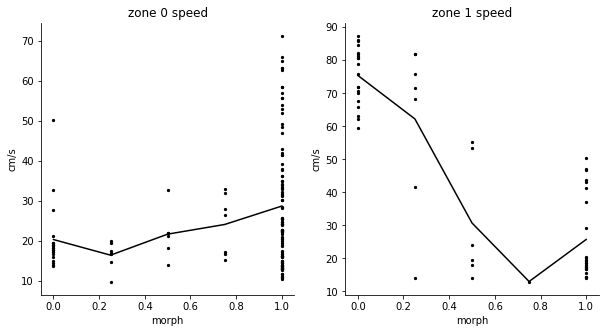

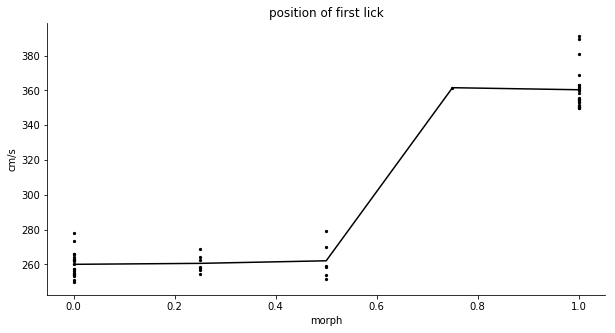

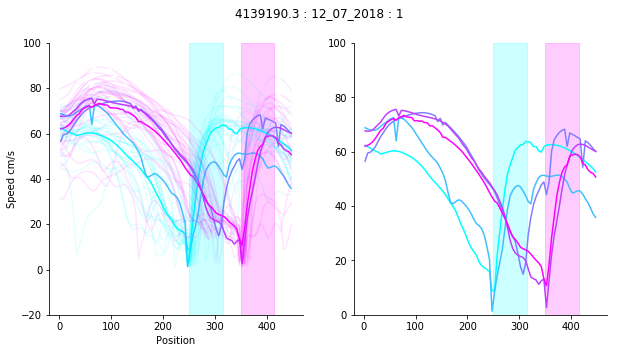

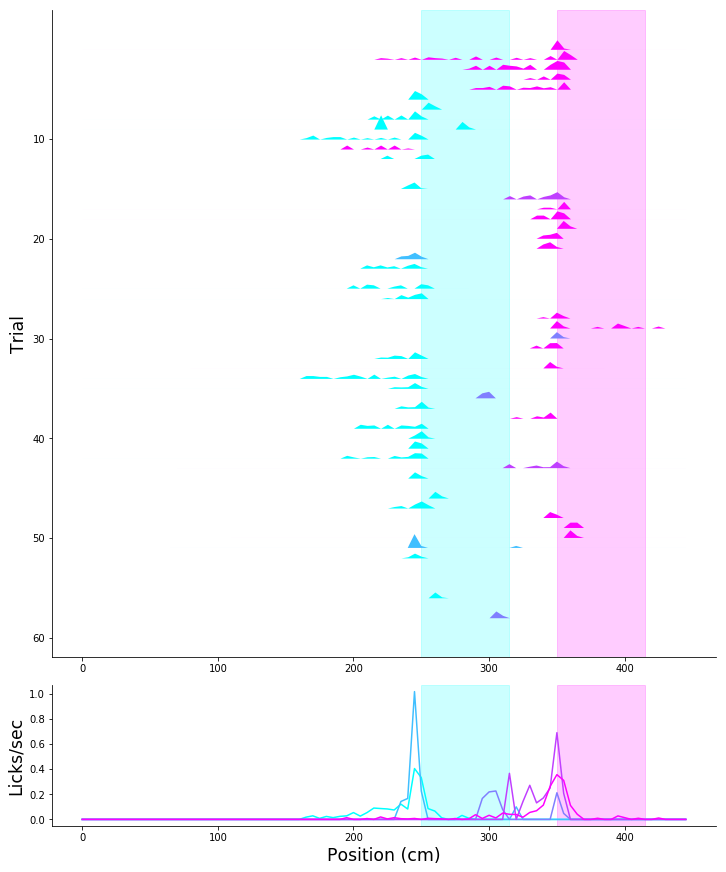

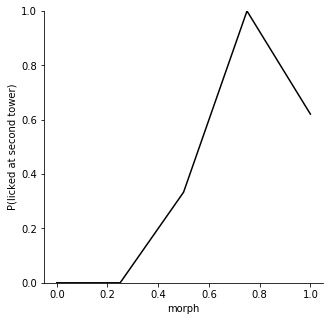

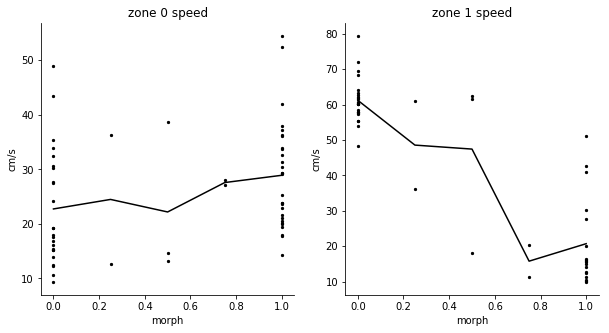

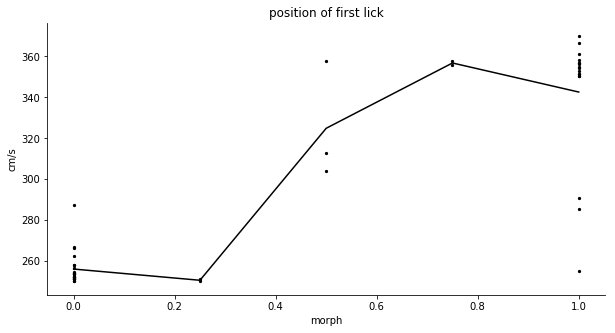

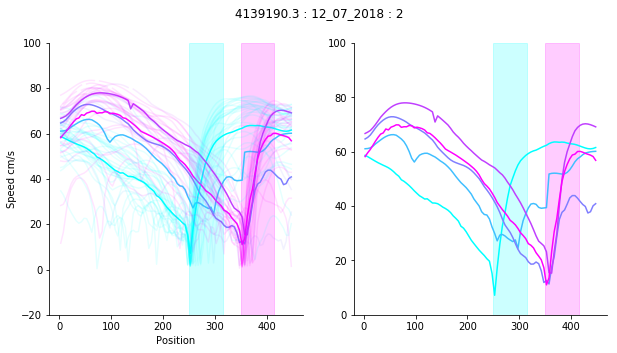

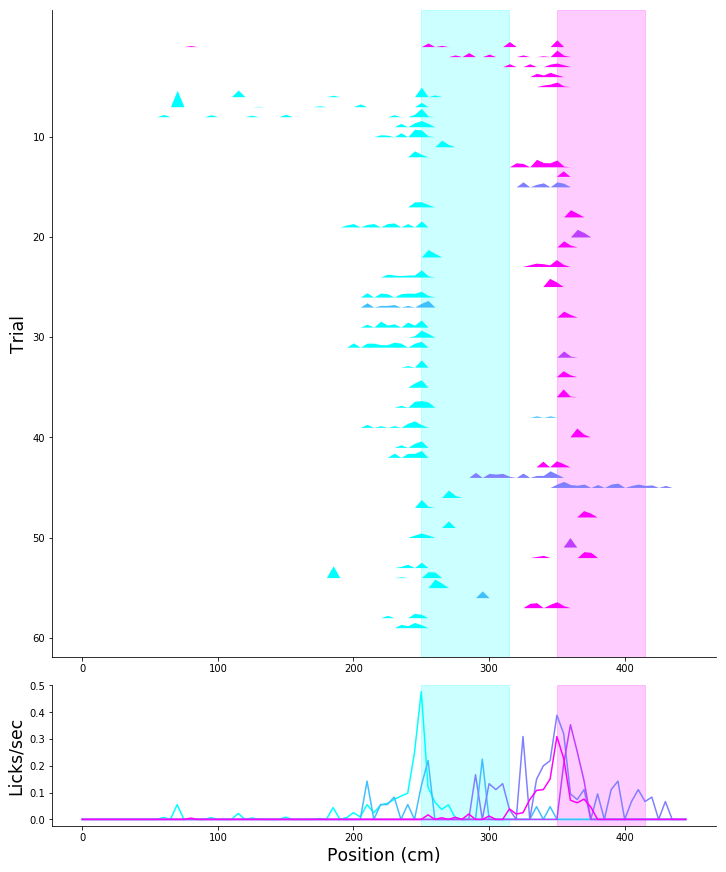

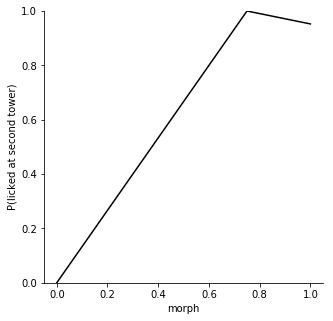

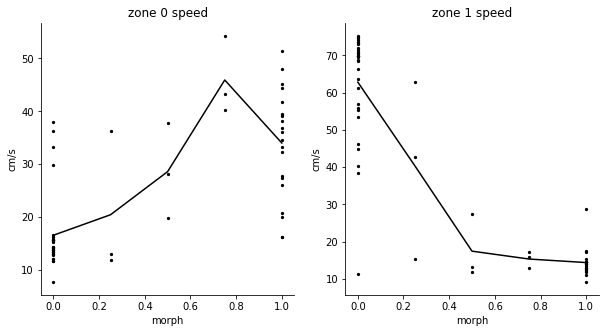

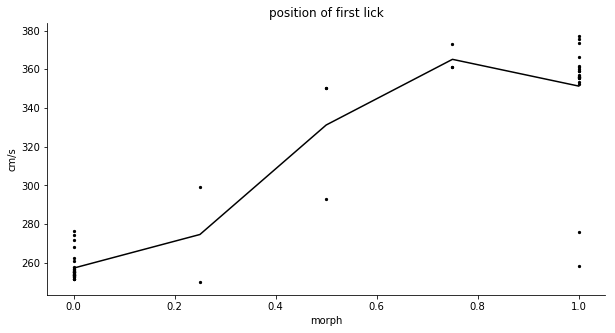

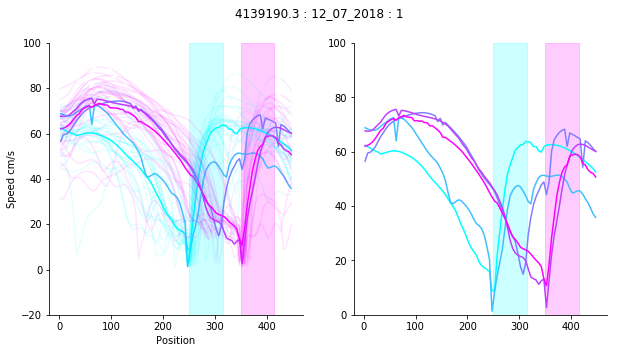

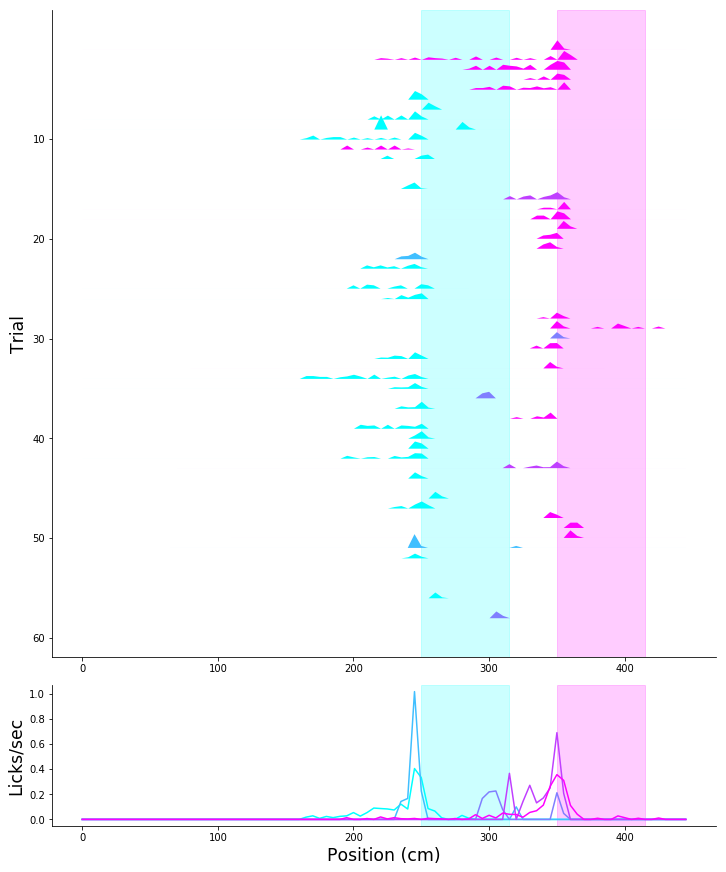

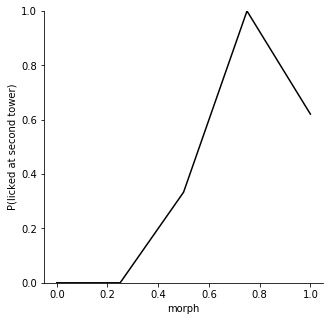

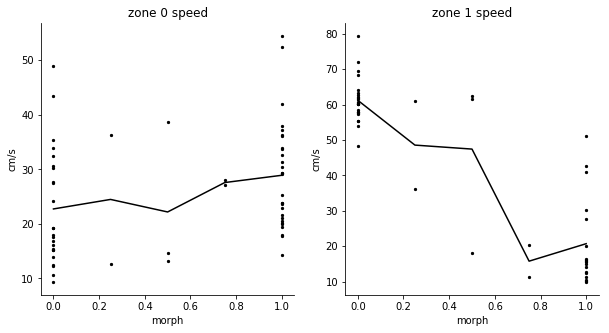

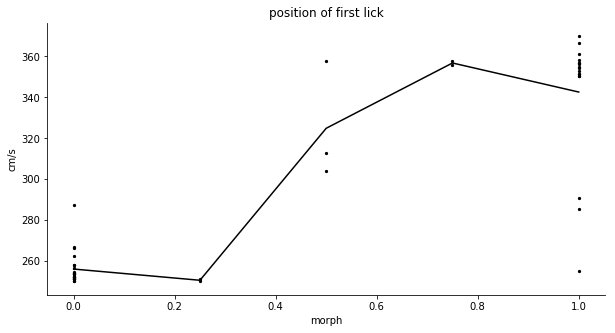

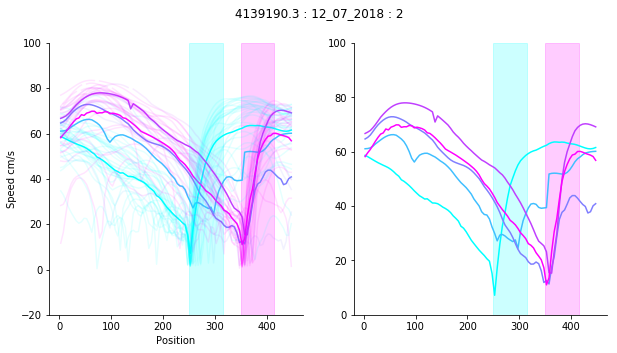

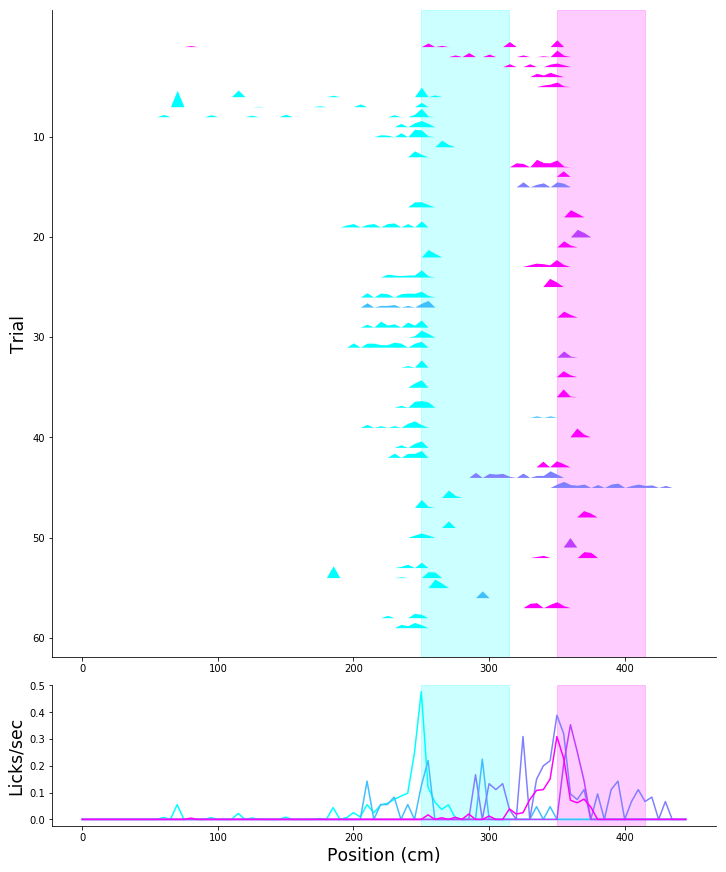

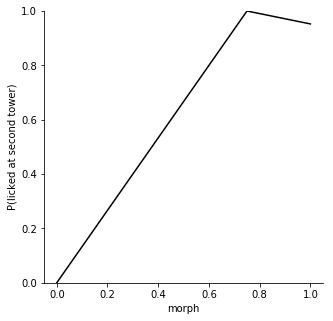

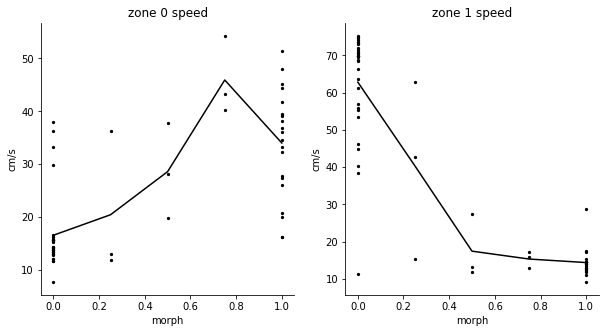

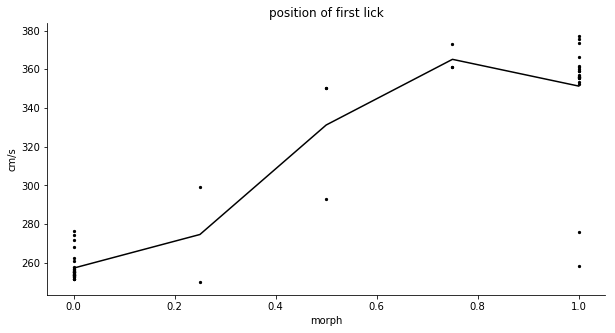

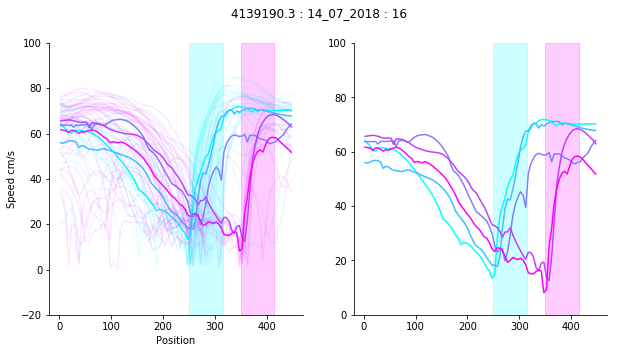

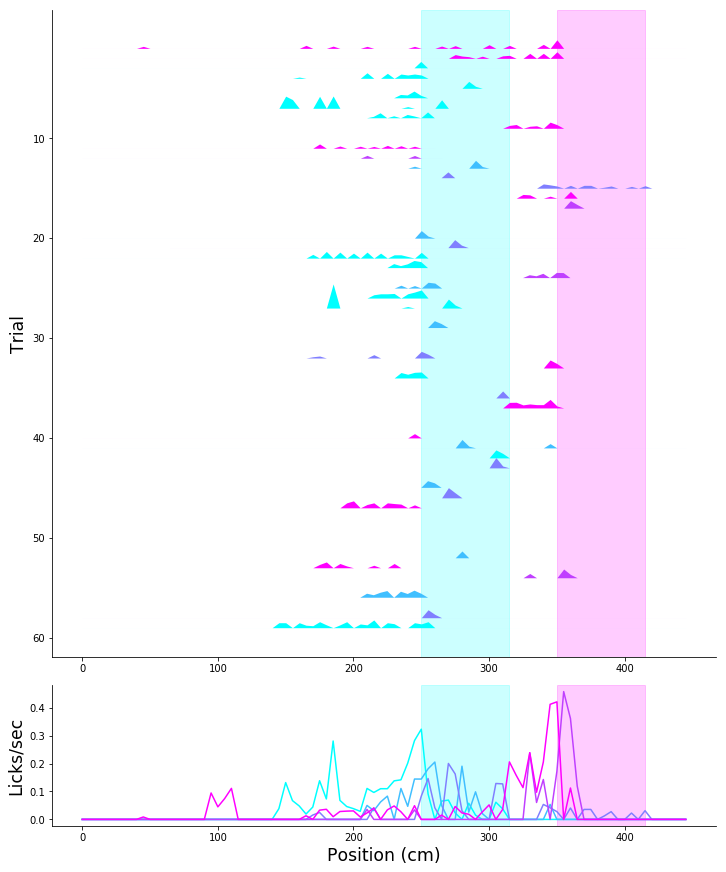

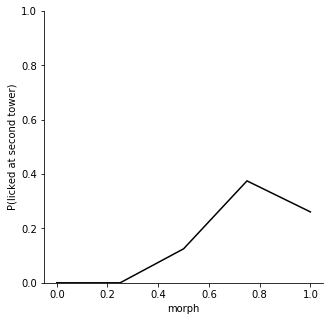

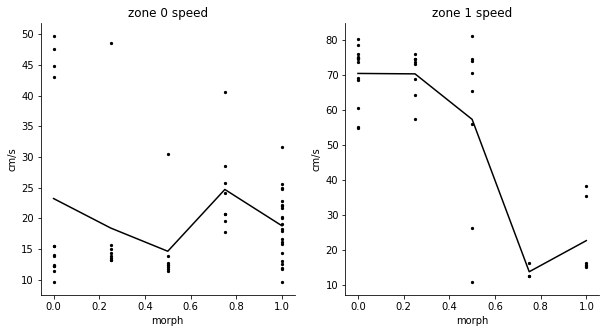

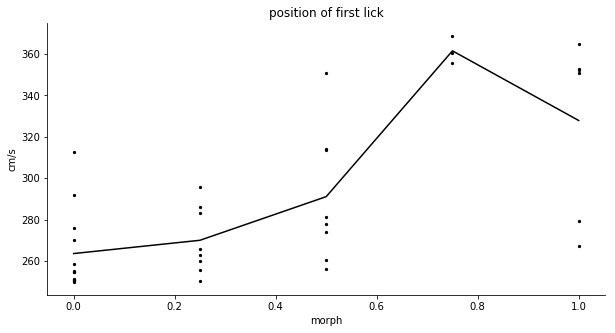

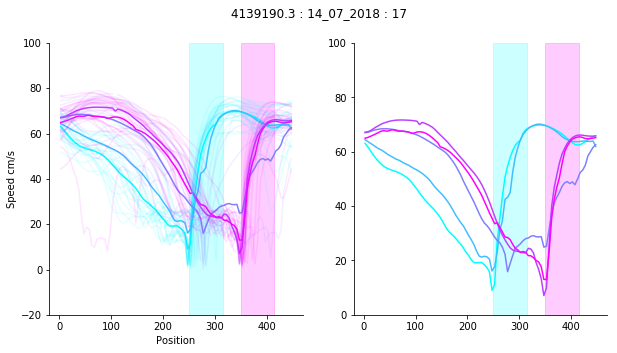

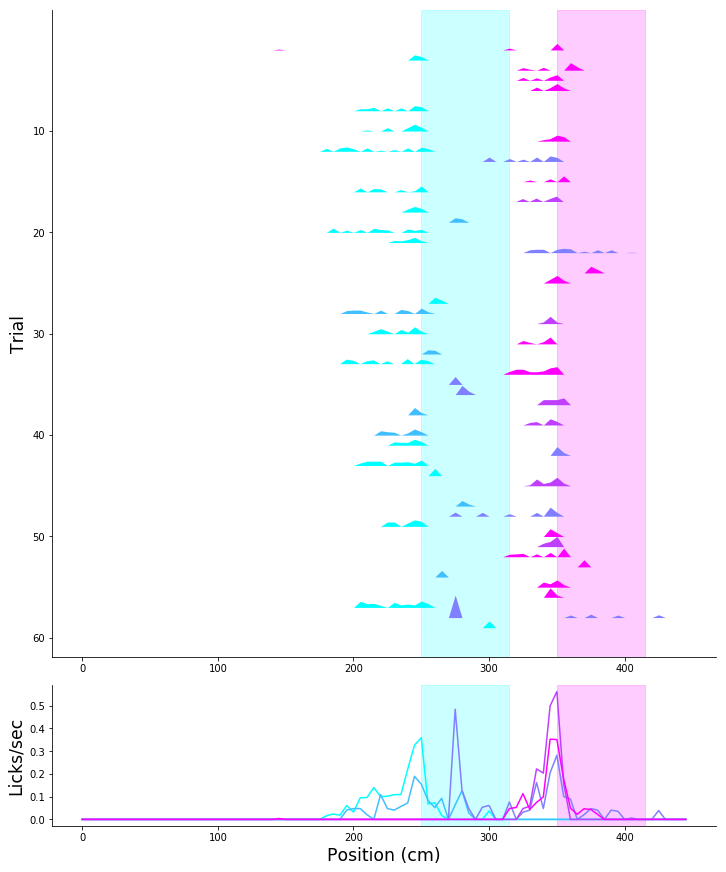

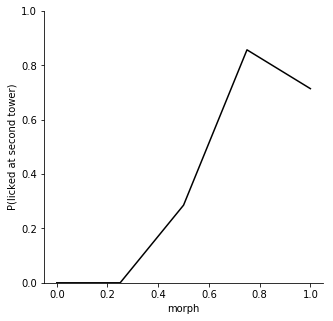

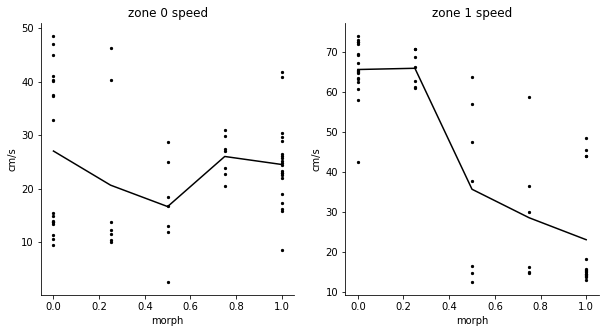

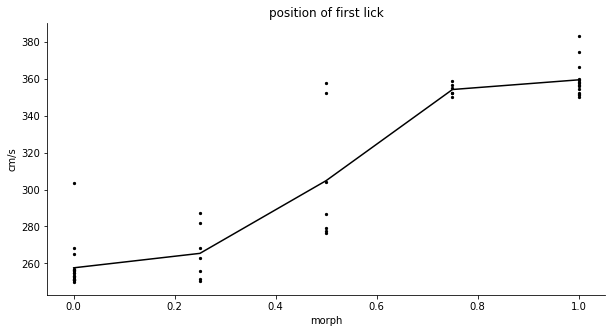

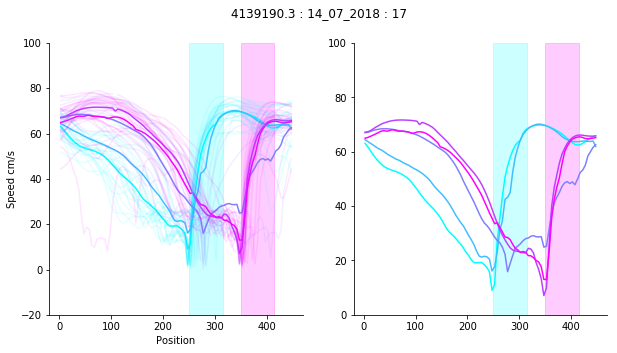

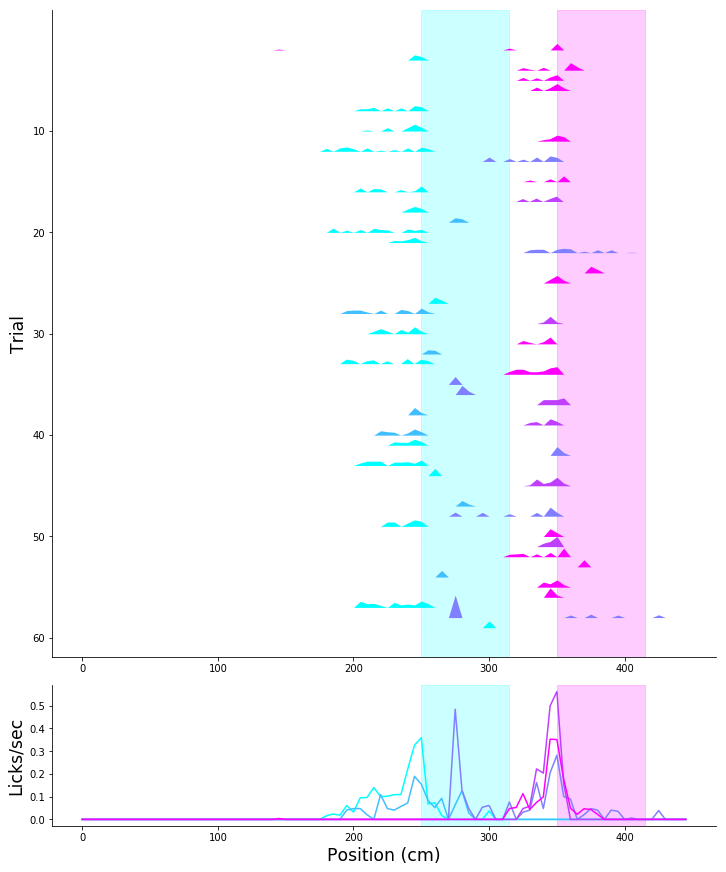

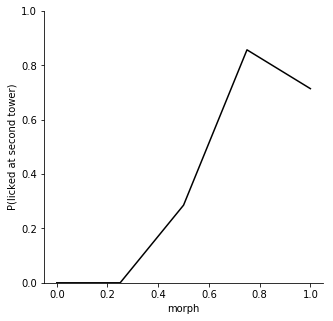

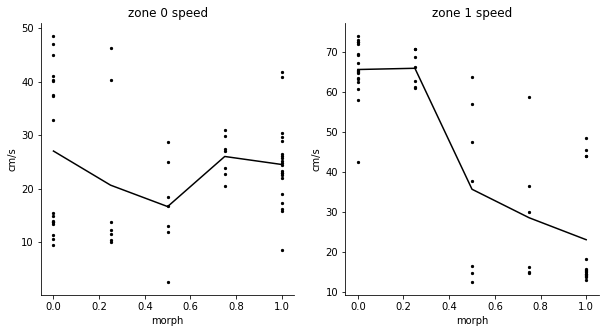

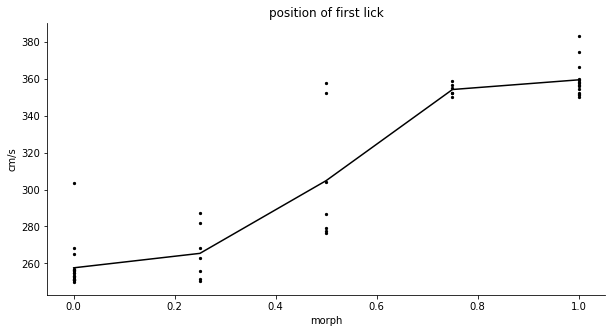

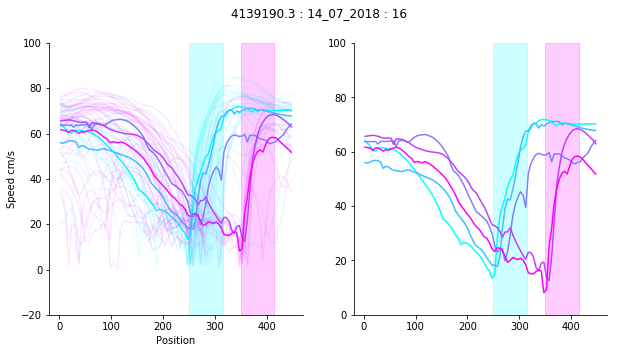

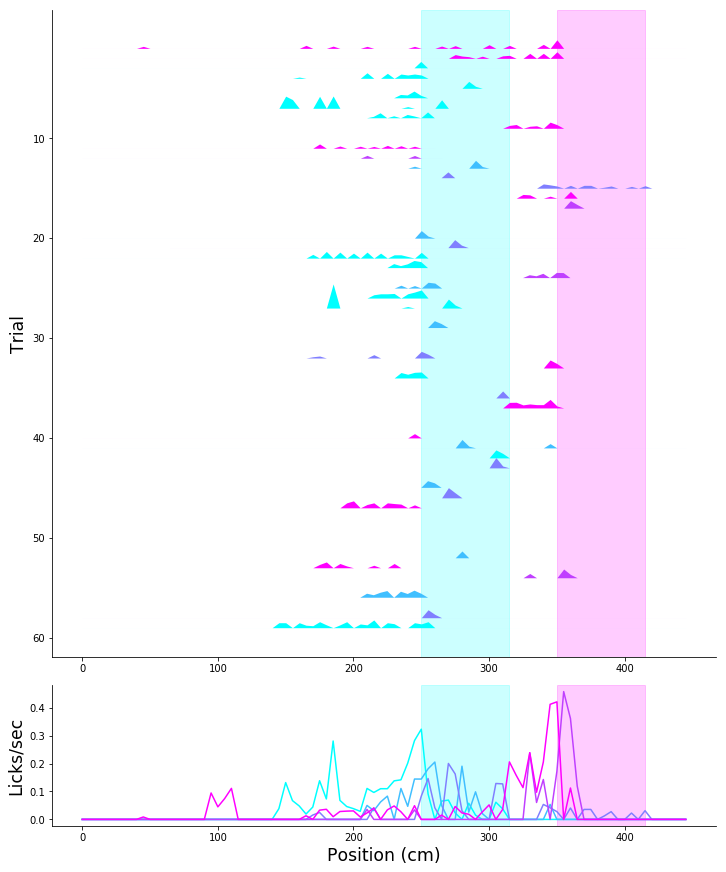

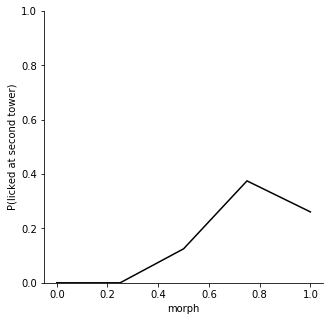

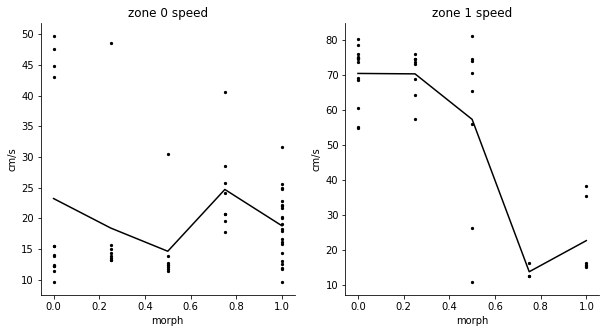

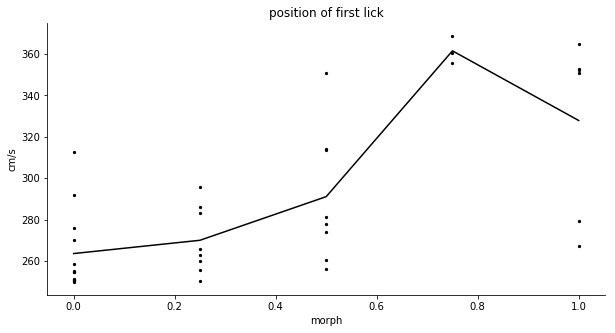

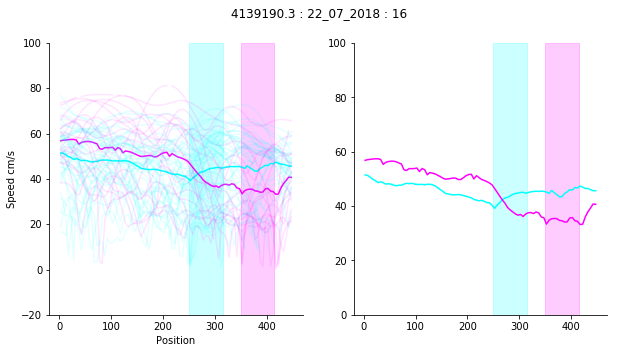

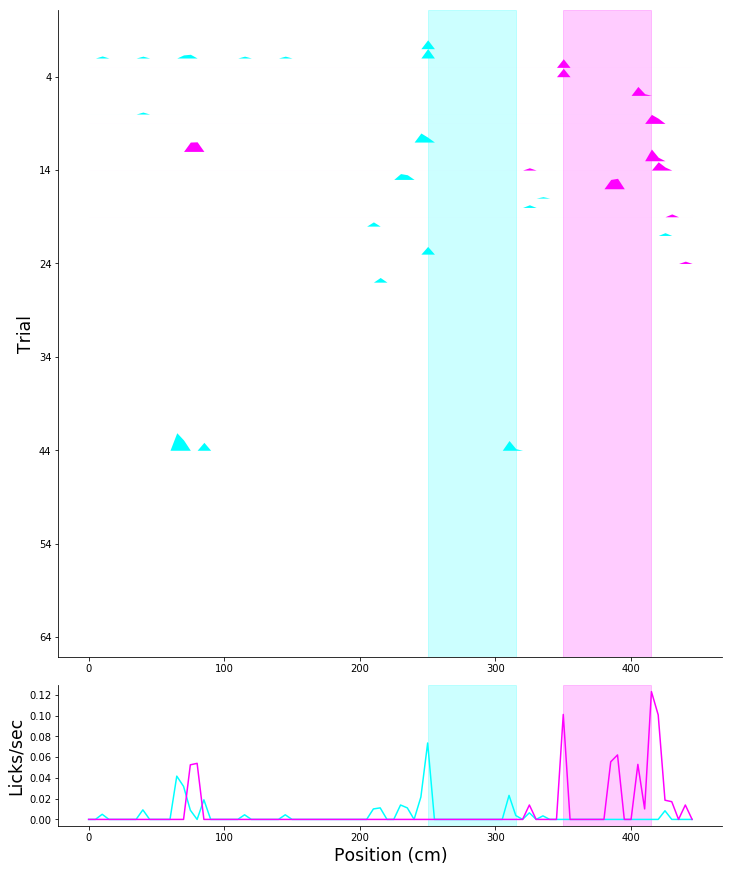

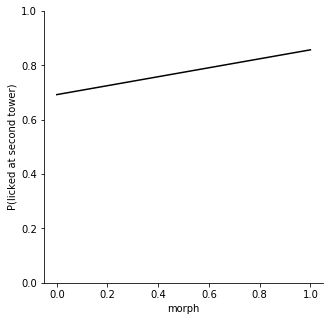

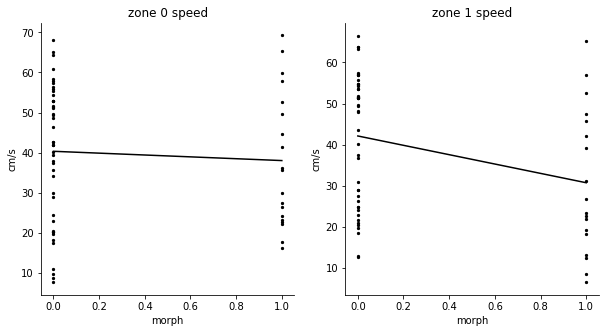

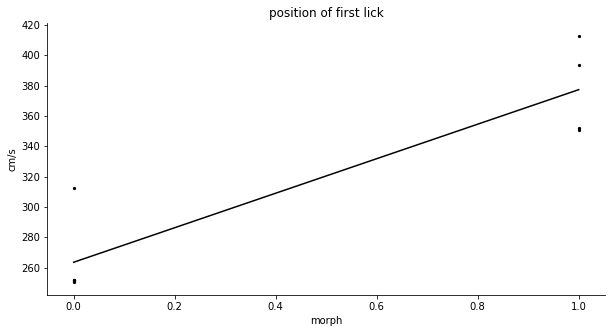

In [34]:
for mouse in ['4139190.3']: #ca1mice+dgmice:
    print(mouse)
    # no timeeout 
    df_TO = df[df['Track']=='TwoTower_Timeout']
    df_TO = df_TO[df_TO['MouseName'].str.match(mouse)]
    df_TO
    # concatenate all files
    data_TOs = behavior_dataframe([df_TO['data file'].iloc[i] for i in range(df_TO.shape[0])],scanmats=[df_TO['scanmat'].iloc[i] for i in range(df_TO.shape[0])],concat=False)

    
    # correct for frame times
    for i,data_TO in enumerate(data_TOs):
       # try:
        trial_mat, bin_edges, bin_centers = make_pos_bin_trial_matrices(data_TO[['speed','morph','lick rate','reward','lick']]._values,
                                                      data_TO['pos']._values,
                                                      data_TO['tstart']._values,
                                                      data_TO['teleport']._values,bin_size=5)
        #except:
            #print(np.where(data_TO['tstart']._values>0)[0],np.where(data_noTO))

       
        morph_vec,count = sp.stats.mode(trial_mat[:,:,1],axis=1,nan_policy='omit')
        morph_vec = np.squeeze(morph_vec)

         # speed vs position
        speed_dict = trial_type_dict(trial_mat[:,:,0],morph_vec)

        f,ax = plot_speed(bin_centers,speed_dict,morph_vec)
        f.suptitle("%s : %s : %s" % (mouse,df_TO['DateFolder'].iloc[i],df_TO['SessionNumber'].iloc[i]))
        

        # plot licking behavior 
        lick_dict = trial_type_dict(trial_mat[:,:,4],morph_vec)
        lick_mat = np.squeeze(trial_mat[:,:,2])
        lick_mat_norm = lick_dict['all']/np.amax(lick_dict['all'])
        lick_norm_dict = trial_type_dict(lick_mat_norm,morph_vec)
        fig,axes = lick_plot(lick_dict,bin_edges,smooth=False,ratio=False)
                   
                   
        trial_info = by_trial_info(data_TO)
        pcnt_mean = avg_by_morph(trial_info['morphs'],trial_info['pcnt'])
        f,ax = plt.subplots(figsize=[5,5])
       # morph_vals = np.arange(0,1.25,.25)
        ax.plot(np.sort(np.unique(morph_vec)),pcnt_mean,color='black')
        #ax.plot(morph_vals,pcnt_mean_post,color='red')
        ax.set_ylabel("P(licked at second tower)")
        ax.set_xlabel("morph")
        ax.set_ylim([0,1])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # zone speeds
        zone0_speed = avg_by_morph(trial_info['morphs'],trial_info['zone0_speed'])
        zone1_speed = avg_by_morph(trial_info['morphs'],trial_info['zone1_speed'])
        f,ax = plt.subplots(1,2,figsize=[10,5])
        #morph_vals = np.arange(0,1.25,.25)
        ax[0].plot(np.sort(np.unique(morph_vec)),zone0_speed,color='black')
        ax[0].scatter(trial_info['morphs'],trial_info['zone0_speed'],color='black',s=5)
        ax[0].set_ylabel("cm/s")
        ax[0].set_xlabel("morph")
        ax[0].set_title("zone 0 speed")
        ax[0].spines['top'].set_visible(False)
        ax[0].spines['right'].set_visible(False)


        ax[1].plot(np.sort(np.unique(morph_vec)),zone1_speed,color='black')
        ax[1].scatter(trial_info['morphs'],trial_info['zone1_speed'],color='black',s=5)
        ax[1].set_ylabel("cm/s")
        ax[1].set_xlabel("morph")
        ax[1].set_title("zone 1 speed")
        ax[1].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False)

        #position of first lick
        pos_lick = avg_by_morph(trial_info['morphs'],trial_info['pos_lick'])
        f,ax = plt.subplots(figsize=[10,5])
        ax.plot(np.sort(np.unique(morph_vec)),pos_lick,color='black')
        ax.scatter(trial_info['morphs'],trial_info['pos_lick'],color='black',s=5)
        ax.set_ylabel("cm/s")
        ax.set_xlabel("morph")
        ax.set_title("position of first lick")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        

In [ ]:

\